## k近傍法　(k-nearest neighbor algorithm, k-NN)
入力パターンに近いk個の学習パターンを取り上げ，最も多数を占めたカテゴリを入力パターンのカテゴリとする．
<br />
<br />
アルゴリズム：
1. 入力パターンと全ての学習パターンとの距離を計算する．
2.  距離の昇順に学習パターンをソートする．
3.  ソートした学習パターンの上位k個を取り上げ，最も出現回数の多いカテゴリを出力する．
<br />
<br />

<img src="http://drive.google.com/uc?export=view&id=1LBVmnghUEy2pLYIBl8M0utWUflh5hB9t" width=500 />

##  目次
- [目標](#目標)
- [下準備](#下準備)
- [距離関数の実装](#距離関数の実装)
- [k近傍法の実装](#k近傍法の実装)
- [k近傍法の実行](#k近傍法の実行)

<a name="目標"></a>
### 目標
- k近傍法で用いる距離関数を実装する．
    - [課題1： コサイン距離の実装](#コサイン距離)
    - [課題2： ユークリッド距離の実装](#ユークリッド距離)
- k近傍法のアルゴリズム全体を実装する．
    - [課題3： k近傍法の実装](#k近傍法)
- MNISTデータと二種類の距離関数を用いてk近傍法を実行する．

<a name="下準備"></a>
### 下準備


#### ライブラリのインストール

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from __future__ import print_function

In [2]:
from google.colab import drive # driveを接続
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# drive中の課題ファイルのあるフォルダへ移動
%cd /content/gdrive/My Drive/先端人工知能論Ⅰ/handson20190514
from test_knn import *

/content/gdrive/My Drive/先端人工知能論Ⅰ/handson20190514


#### MNISTデータの読み込み
X：画像データ(各画像784次元）， Y：ラベル

In [4]:
mnist = fetch_mldata('MNIST original', data_home='./data/')
X, Y = mnist.data, mnist.target
X = np.array(X/255.0, dtype=np.float32)
Y = np.array(Y, dtype=np.uint8)
# class数
class_num = 10
print("X.shape: " + str(X.shape), ", Y.shape: " + str(Y.shape))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


X.shape: (70000, 784) , Y.shape: (70000,)


#### データセットの可視化

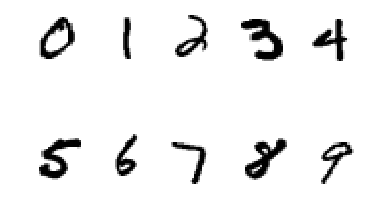

In [5]:
for i in range(class_num):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i * 6500].reshape(28, 28), cmap='gray_r')
    plt.axis("off")

#### データセットの削減
距離の計算にかなり時間がかかるためデータセットを70000から3000に削減する

In [0]:
np.random.seed(100)
random_sample = np.arange(len(X))
np.random.shuffle(random_sample)
X = X[random_sample[:3000]]
Y = Y[random_sample[:3000]]

#### 学習用・検証用・テスト用データの分割
- 学習用データ(train_x, train_y)：入力パターンのラベルを決定するために用いるデータ
- 検証用データ(val_x, val_y)：最適なハイパーパラメータ（k）を算出するためのデータ
- テスト用データ(test_x, test_y)：検証用データを用いて算出されたハイパーパラメータを用いて手法の性能をテストするためのデータ

In [0]:
#テスト用データを分ける
train_X, test_x, train_Y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2)
#学習用データと検証用データを分ける
train_x, val_x, train_y, val_y = train_test_split(train_X, train_Y, test_size=0.1, random_state=42)

In [8]:
print('train data:',train_x.shape,', train label:',train_y.shape)
print('val data:   ',val_x.shape,',    val label:   ',val_y.shape)
print('test data: ',test_x.shape,',   test label: ',test_y.shape)

train data: (2160, 784) , train label: (2160,)
val data:    (240, 784) ,    val label:    (240,)
test data:  (600, 784) ,   test label:  (600,)


### 距離関数の実装
<a name="距離関数の実装"></a>

<a name="コサイン距離"></a>
<h4><font color="Orange">
課題1：コサイン距離の実装
</h4>
</font>

- 関数：cosine_distance
 
    - 入力：$\boldsymbol{X}=(\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots\boldsymbol{x}_{N})^{T}\in\mathbb{R}^{N\times D},　\boldsymbol{Y}=(\boldsymbol{y}_1,\boldsymbol{y}_2,\cdots\boldsymbol{y}_{M})^{T}\in\mathbb{R}^{M\times D}$
      
    - 出力：$\boldsymbol{Z}\in\mathbb{R}^{N\times M},　z_{nm}=cos(\boldsymbol{x}_n,\boldsymbol{y}_m)$
    
    

- コサイン距離 :
$$ 
cos(\boldsymbol{x},\boldsymbol{y}) = 1- \frac{\boldsymbol{x}\boldsymbol{y}}{|\boldsymbol{x}||\boldsymbol{y}|}\\
$$

<details>
<summary>
課題1：ヒント
</summary>
<ol>
    <li>Zの初期化（Xの要素数$\times$Yの要素数）
    <ul> 
        <li>要素が0の配列を生成：`np.zeros(shape)`</li>
        <li>Xの要素数：`X.shape[0]`</li>
    </ul></li>
    <li>Z[n][m]にX[n]とY[m]のコサイン距離を代入
    <ul>
    <li>ベクトルX[n]のノルム計算：`np.linalg.norm(X[n])`</li>
    <li>ベクトルX[n]とY[m]の内積：`np.dot(X[n], Y[m])`</li>
    </ul></li>
    </ol>
</details>

In [0]:
def cosine_distance(X, Y):
    def calc_cosine_distance(x, y):
        return 1.0 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    
    Z = np.empty((len(X), len(Y)))
    for n, x in enumerate(X):
        for m, y in enumerate(Y):
            z = calc_cosine_distance(x, y)
            Z[n][m] = z
    return Z

#### 課題1のテスト
OKが表示されたら次に進む

In [12]:
test_cosine(cosine_distance)

OK


<a name="ユークリッド距離"></a>
<h4><font color="Orange">
課題2：ユークリッド距離の実装
</h4>
</font>

- 関数：euclidian_distance

    - 入力：$\boldsymbol{X}=(\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots\boldsymbol{x}_{N})^{T}\in\mathbb{R}^{N\times d}$,　$\boldsymbol{Y}=(\boldsymbol{y}_1,\boldsymbol{y}_2,\cdots\boldsymbol{y}_{M})^{T}\in\mathbb{R}^{M\times d}$
  
    - 出力：$\boldsymbol{Z}\in\mathbb{R}^{N\times M},　z_{nm}=d(\boldsymbol{x}_n,\boldsymbol{y}_m)$

- ユークリッド距離 :
$$ d(x,y)=\sqrt{(x_1-y_1)^2+(x_2-y_2)^2+\cdots(x_D-y_D)^2} $$

<details>
<summary>
課題2：ヒント
</summary>
<ol>
    <li>Zの初期化（Xの要素数×Yの要素数）
    <ul> 
        <li>要素が0の配列を生成：`np.zeros(shape)`</li>
        <li>Xの要素数：`X.shape[0]`</li>
    </ul></li>
    <li>Z[n][m]にX[n]とY[m]のユークリッド距離を代入
    <ul>
    <li>ベクトルのノルム計算：`np.linalg.norm(X[n])`</li>
    </ul></li>
    </ol>
</details>

In [0]:
def euclidean_distance(X, Y):
    def calc_eucilidean_distance(x, y):
        return np.linalg.norm(x - y)
    
    Z = np.empty((len(X), len(Y)))
    for n, x in enumerate(X):
        for m, y in enumerate(Y):
            z = calc_eucilidean_distance(x, y)
            Z[n][m] = z
    return Z

#### 課題2のテスト
OKが表示されたら次に進む

In [16]:
test_euclidean(euclidean_distance)

OK


<a name="k近傍法の実装"></a>
### k近傍法の実装

<a name="k近傍法"></a>
<h4><font color="Orange">
課題3：k近傍法の実装
</h4>
</font>

- 関数：KNN.prediction
    - 入力：
        - 入力パターン：$\boldsymbol{X}=(\boldsymbol{x_1},\boldsymbol{x_2},\cdots,\boldsymbol{x_N})^T\in\mathbb{R}^{N\times D}$
        - k近傍法のk: $k$
    - 出力：
        - 入力パターンの予測ラベル：$\boldsymbol{Y}=(y_1,y_2,\cdots,y_N)\in\mathbb{R}^{N}$
    - インスタンス変数
        - 学習データ：self.train_x
        - 学習ラベル：self.train_y
        - 距離関数：distance_func()
    

<details>
<summary>
課題3：ヒント1（入力パターンXと全ての学習パターンself.train_xとの距離を計算する）
</summary>
<ul>
        <li> `distance_matrix = self.distance_func(X, self.train_x)`<br>
            <img src="https://drive.google.com/uc?export=download&id=16uPwCC1eCXweQEMh1YfqUUf4uw17n-Wm" width="360" height="280"></li>
</ul>
</details>

<details>
<summary>
課題3：ヒント2（距離の昇順に学習パターンをソートする）
</summary>
    <ul>
    <li>`sort_index = np.argsort(distance_matrix, axis = 1)`<br>
    <img src="https://drive.google.com/uc?export=download&id=1vEbZ-JVtGw9flDAH2D78NMDMkKb7i08-" width="600" height="300"></li>
   </ul>

<details>
<summary>
課題3：ヒント3（ソートした学習パターンの上位k個を取り上げ，最も出現回数の多いカテゴリを出力する ）
</summary>
<ul>
    <li>上位k個のインデックスを取り出す：`nearest_k = sort_index[???]`</li>
    <li>上位k個のラベルを取り出す：`labels = self.train_y[nearest_k]`</li>
    <li>上位k個のラベルに各ラベルが何個ずつ含まれるか調べる：<br>
    <img src="https://drive.google.com/uc?export=download&id=1TBgXDPKdDwKXYcJWPkkpT7cDSvR3NA_M"　width="600" height="128">
    <ul>
        <li>np.eye(class_num)[labels]でラベルをone-hot表現にする<br>
        <img src="https://drive.google.com/uc?export=download&id=11KSxXUN2lnMxOTj6G4c6OwyltxTnDh62"　width="350" height="300">
        <li>axis=1方向に合計をとる<br>
        <img src="https://drive.google.com/uc?export=download&id=10eN_L6t1wN3B1Gw-m2Zg0mxThfssfAAg"　width="350" height="100"><br>
     <li>上位k個のラベルで最も多いラベルを調べる：np.argmax()</li>
    </ul></li>
    </ul>
</details>

In [0]:
class KNN:
    def __init__(self, x, y, func=cosine_distance):
        self.train_x = x
        self.train_y = y
        self.distance_func = func
    
    #入力パターンに対して予測ラベルを返す
    def prediction(self, X, k):
        distance = self.distance_func(X, self.train_x)
        index_k = np.argsort(distance, axis=1)[:, :k]
        labels = self.train_y[index_k]
        one_hot = np.identity(10)[labels]
        count = np.sum(one_hot, axis=1)
        Y = np.argmax(count, axis=1)
        return Y
    
    #予測データと正解データを用いてaccuracyを計算する
    def get_accuracy(self, pred, real, eval_func=accuracy_score):
        accuracy = eval_func(pred, real)
        return accuracy
    
    # 最適なkを見つけるためにkを変化させて予測を行い，最も性能が高いkを返す
    def find_k(self, val_x, val_y, k_list):
        score_list = []
        #for k in tqdm(k_list): 
        for k in k_list:
            pred = self.prediction(val_x, k)
            accuracy = self.get_accuracy(pred, val_y)
            print('k：{0}, accuracy：{1:.5f}'.format(k,accuracy))
            score_list.append(accuracy)

        top_ind = np.argmax(score_list)
        best_k = k_list[top_ind]
        print('best k : {0}, val score : {1:.5f}'.format(best_k,score_list[top_ind]))
        return best_k

#### 課題3のテスト
OKが表示されたら次に進む

In [28]:
test_knn(KNN)

OK


### k近傍法の実行
<a name="k近傍法の実行"></a>

#### コサイン距離を用いる場合

In [31]:
#インスタンス生成
knn = KNN(train_x, train_y, func = cosine_distance)
#検証用データval_xを用いて最適なkを算出する
k_list = np.arange(1,21,2)
best_k = knn.find_k(val_x, val_y, k_list)
#検証用データで算出したkを用いてテストデータのクラスを予測する
pred_y = knn.prediction(test_x, best_k)
#正解率の計算
result = knn.get_accuracy(pred_y, test_y)
print('test_accuracy :　{0:.5f}'.format(result))

k：1, accuracy：0.92500
k：3, accuracy：0.93750
k：5, accuracy：0.95000
k：7, accuracy：0.95000
k：9, accuracy：0.95000
k：11, accuracy：0.94583
k：13, accuracy：0.95000
k：15, accuracy：0.94167
k：17, accuracy：0.94583
k：19, accuracy：0.93750
best k : 5, val score : 0.95000
test_accuracy :　0.91833


#### ユークリッド距離を用いる場合

In [32]:
knn = KNN(train_x, train_y, func = euclidean_distance)
#検証用データval_xを用いて最適なkを算出する
k_list = np.arange(1,21,2)
best_k = knn.find_k(val_x, val_y, k_list)
#検証用データで算出したkを用いてテストデータのクラスを予測する
pred_y = knn.prediction(test_x, best_k)
#正解率の計算
result = knn.get_accuracy(pred_y, test_y)
print('test_accuracy :　{0:.5f}'.format(result))

k：1, accuracy：0.91250
k：3, accuracy：0.91667
k：5, accuracy：0.92500
k：7, accuracy：0.93750
k：9, accuracy：0.91667
k：11, accuracy：0.90833
k：13, accuracy：0.90417
k：15, accuracy：0.89167
k：17, accuracy：0.90000
k：19, accuracy：0.90000
best k : 7, val score : 0.93750
test_accuracy :　0.90833


test_accuracyがいずれの場合も約90パーセントであれば正解である．

k近傍法はシンプルだが，入力パターンと学習パターンの全てに対して距離を計算しなければならないので，識別に時間がかかる．<br>
コサイン距離やユークリッド距離を計算する際にfor文を使わない実装例を解答に示したので確認してみよう．